# II. Feature Engineering (and some ML)

Next we want to know what our dataset should look like if we want to feed it to our upcomming models.
This includes:
- treatment of categoricals
- Scaling
- Addition of more features

In [1]:
import os
import pandas as pd
from dotenv import load_dotenv
from pathlib import Path

load_dotenv()

True

Lets start by loading our dataset:

In [2]:
# Data file paths
data_dir = os.getenv("DATA")
dataset_df = pd.read_csv(Path(data_dir) / "dataset.csv")
dataset_df = dataset_df.astype({"Vertriebskanal": "category", "Regional_Code": "category"})
dataset_df = dataset_df.sort_values(by=["id"])
for col in dataset_df:
    if dataset_df[col].dtype == "object":
        dataset_df[col] = dataset_df[col].astype("category")
dataset_df.head()

,id,Geschlecht,Alter,Interesse,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue
0,1,Male,44,1,1,28,0,> 2 Years,Yes,40454.0,26.0,217
1,2,Male,76,0,1,3,0,1-2 Year,No,33536.0,26.0,183
2,3,Male,47,1,1,28,0,> 2 Years,Yes,38294.0,26.0,27
3,4,Male,21,0,1,11,1,< 1 Year,No,28619.0,152.0,203
4,5,Female,29,0,1,41,1,< 1 Year,No,27496.0,152.0,39


## 1. Encoding

Here we treat our categorical features. This is how we are going to approach this:
- id: drop 
    - we don't want to train on the ID as this would kill generalization
- regional code: one-hot
    - no inherent ranking
- vertriebs channel: one-hot
    - no inherent ranking
- vehicle age: ordinal
    - Inherently ranks the age of the vehicle
- Vorschaden: binary

In [3]:
target = dataset_df.pop("Interesse")
target = pd.concat([target, dataset_df["id"]], axis=1)
target.to_csv(Path(data_dir) / "target.csv", index=False)

In [4]:
one_hot_df = pd.get_dummies(dataset_df, columns=['Regional_Code', 'Vertriebskanal'])
# Using dictionary comprehension to handle the encoding and then creating the DataFrame
encoded_data = {
    col: one_hot_df[col].cat.codes if one_hot_df[col].dtype.name == "category" else one_hot_df[col]
    for col in one_hot_df.columns
}

# Create DataFrame from the dictionary
encoded_df = pd.DataFrame(encoded_data).astype(float)

# Check dtypes of the resulting DataFrame
encoded_df.head()
# one_hot_df = dataset_df

,id,Geschlecht,Alter,Fahrerlaubnis,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Kundentreue,Regional_Code_0,...,Vertriebskanal_152.0,Vertriebskanal_153.0,Vertriebskanal_154.0,Vertriebskanal_155.0,Vertriebskanal_156.0,Vertriebskanal_157.0,Vertriebskanal_158.0,Vertriebskanal_159.0,Vertriebskanal_160.0,Vertriebskanal_163.0
0,1.0,1.0,44.0,1.0,0.0,2.0,1.0,40454.0,217.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,1.0,76.0,1.0,0.0,0.0,0.0,33536.0,183.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,1.0,47.0,1.0,0.0,2.0,1.0,38294.0,27.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,1.0,21.0,1.0,1.0,1.0,0.0,28619.0,203.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5.0,0.0,29.0,1.0,1.0,1.0,0.0,27496.0,39.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
ordinal_data = {
    col: dataset_df[col].cat.codes if dataset_df[col].dtype.name == "category" else dataset_df[col]
    for col in dataset_df.columns
}

ordinal_df = pd.DataFrame(ordinal_data).astype(float)
ordinal_df.head()

,id,Geschlecht,Alter,Fahrerlaubnis,Regional_Code,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Vertriebskanal,Kundentreue
0,1.0,1.0,44.0,1.0,28.0,0.0,2.0,1.0,40454.0,24.0,217.0
1,2.0,1.0,76.0,1.0,3.0,0.0,0.0,0.0,33536.0,24.0,183.0
2,3.0,1.0,47.0,1.0,28.0,0.0,2.0,1.0,38294.0,24.0,27.0
3,4.0,1.0,21.0,1.0,11.0,1.0,1.0,0.0,28619.0,145.0,203.0
4,5.0,0.0,29.0,1.0,41.0,1.0,1.0,0.0,27496.0,145.0,39.0


## 2. Scaling

Well done, we have encoded out feature. Next we need them scale in order not to confuse our network/models. We start with normal scaling, necessary for log-reg and do min-max scaling, which is recommended for DNNs.
Random forest do not need scaling but we'll compare its effects anyways.

In [6]:
sub_encoded_df = encoded_df.sample(n=10000, random_state=42)
sub_targets_df = target.loc[sub_encoded_df.index]
sub_ordinal_df = ordinal_df.loc[sub_encoded_df.index]

# Can't train on ID
sub_ordinal_df = sub_ordinal_df.drop(columns="id")
sub_encoded_df = sub_encoded_df.drop(columns="id")
sub_targets_df = sub_targets_df.drop(columns="id")
print(sub_targets_df["Interesse"].sum()) # Check if positives in class
print(sub_encoded_df.shape)
print(sub_targets_df.shape)
targets = sub_targets_df["Interesse"]

1332
(10000, 216)
(10000, 1)


In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

### 2.1 Standard Scaling

Let's start with standard scaling:

In [8]:
# Let's start by scaling the data (no feature can rule them all)
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(sub_encoded_df), columns=sub_encoded_df.columns)
scaled_df.head()

,Geschlecht,Alter,Fahrerlaubnis,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Kundentreue,Regional_Code_0,Regional_Code_1,...,Vertriebskanal_152.0,Vertriebskanal_153.0,Vertriebskanal_154.0,Vertriebskanal_155.0,Vertriebskanal_156.0,Vertriebskanal_157.0,Vertriebskanal_158.0,Vertriebskanal_159.0,Vertriebskanal_160.0,Vertriebskanal_163.0
0,-1.082165,-1.157327,0.04363,1.108002,0.844836,-1.023271,-0.558010,-0.966776,-0.077039,-0.04363,...,-0.729289,-0.040032,-0.12792,-0.052032,-0.18005,-0.13462,-0.04363,-0.017323,4.041166,-0.09259
1,0.924073,1.028869,0.04363,-0.902526,-0.885322,0.977259,0.383068,-0.610582,-0.077039,-0.04363,...,-0.729289,-0.040032,-0.12792,-0.052032,-0.18005,-0.13462,-0.04363,-0.017323,-0.247453,-0.09259
2,-1.082165,0.128670,0.04363,-0.902526,-0.885322,0.977259,-1.536973,-0.753059,-0.077039,-0.04363,...,-0.729289,-0.040032,-0.12792,-0.052032,-0.18005,-0.13462,-0.04363,-0.017323,-0.247453,-0.09259
3,-1.082165,-0.835828,0.04363,-0.902526,0.844836,-1.023271,-1.536973,1.360358,-0.077039,-0.04363,...,-0.729289,-0.040032,-0.12792,-0.052032,-0.18005,-0.13462,-0.04363,-0.017323,-0.247453,-0.09259
4,0.924073,0.771669,0.04363,-0.902526,-0.885322,0.977259,0.190777,1.324739,-0.077039,-0.04363,...,-0.729289,-0.040032,-0.12792,-0.052032,-0.18005,-0.13462,-0.04363,-0.017323,-0.247453,-0.09259


In [10]:
from evaluators import evaluate_model, evaluate_network

evaluate_model(scaled_df.values, targets, model=RandomForestClassifier(random_state=42), n_splits=3)
evaluate_model(scaled_df.values,
               targets,
               model=LogisticRegression(random_state=42, max_iter=1000),
               n_splits=3)
evaluate_network(scaled_df.values, targets.values, n_fold=3)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


ROC AUC scores for each fold: [0.83731296 0.84659298 0.8356507 ]
Average ROC AUC: 0.8398522124394172
PR AUC scores for each fold: [0.35911309 0.37114121 0.34297358]
Average PR AUC: 0.357742624902126
F1 scores for each fold: [0.20373514 0.20701169 0.21487603]
Average F1 score: 0.20854095450460589


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


ROC AUC scores for each fold: [0.84125596 0.8580271  0.8439914 ]
Average ROC AUC: 0.8477581549979775
PR AUC scores for each fold: [0.35828683 0.37744235 0.36824238]
Average PR AUC: 0.36799051787313664
F1 scores for each fold: [0.13729128 0.08450704 0.10337972]
Average F1 score: 0.10839268135730808

Loss: 137.36734019219875
Loss: 118.086077965796
Loss: 114.55826283246279
Loss: 112.33454644307494
Loss: 110.2999216299504
Loss: 108.96504702046514
Loss: 107.37786889821291
Loss: 105.3904002532363
Loss: 104.18636382929981
Loss: 102.41617637500167
Loss: 100.49293264374137
Loss: 97.4874668372795
Loss: 96.5999358817935
Loss: 94.4810567041859
Loss: 93.09703752957284
Loss: 89.47795150056481
Loss: 88.21732089808211
Loss: 85.97162703610957
Loss: 83.46740683913231
Loss: 82.13019990362227
Loss: 134.28961903229356
Loss: 115.2654446810484
Loss: 112.02243791893125
Loss: 110.37355095520616
Loss: 108.55789270438254
Loss: 106.24994981661439
Loss: 105.03643855080009
Loss: 103.00879048742354
Loss: 101.1195452

(0.8206447438779705, 0.3410995188073529, 0.2776011480222342)

### 2.2 Min-Max Scaling

Let's continue with minmax scaling. As we can se there is not a big difference to standard scaling in the obtained results

In [12]:
# Let's start by scaling the data (no feature can rule them all)
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler = MinMaxScaler()
minmax_df = pd.DataFrame(scaler.fit_transform(sub_encoded_df), columns=sub_encoded_df.columns)
minmax_df.head()

,Geschlecht,Alter,Fahrerlaubnis,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Kundentreue,Regional_Code_0,Regional_Code_1,...,Vertriebskanal_152.0,Vertriebskanal_153.0,Vertriebskanal_154.0,Vertriebskanal_155.0,Vertriebskanal_156.0,Vertriebskanal_157.0,Vertriebskanal_158.0,Vertriebskanal_159.0,Vertriebskanal_160.0,Vertriebskanal_163.0
0,0.0,0.015385,1.0,1.0,0.5,0.0,0.039903,0.214533,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.538462,1.0,0.0,0.0,1.0,0.078263,0.318339,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.323077,1.0,0.0,0.0,1.0,0.000000,0.276817,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.092308,1.0,0.0,0.5,0.0,0.000000,0.892734,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.476923,1.0,0.0,0.0,1.0,0.070425,0.882353,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
evaluate_network(minmax_df.values, targets.values, n_fold=3)


Loss: 136.60133302398026
Loss: 116.02343177609146
Loss: 114.13453093729913
Loss: 112.2901142090559
Loss: 111.30422175303102
Loss: 109.8413908034563
Loss: 108.29987532272935
Loss: 106.99441274628043
Loss: 105.07178782299161
Loss: 103.27565440535545
Loss: 101.52779064606875
Loss: 98.94714685156941
Loss: 98.06768978387117
Loss: 95.49973926320672
Loss: 94.14035923825577
Loss: 91.81990451924503
Loss: 91.55455473996699
Loss: 89.50208370946348
Loss: 88.05548504926264
Loss: 86.31756466068327
Loss: 137.01868231594563
Loss: 118.55091037321836
Loss: 115.7094548754394
Loss: 114.42854859679937
Loss: 112.62998876348138
Loss: 110.63388279825449
Loss: 109.00881931558251
Loss: 107.08676116168499
Loss: 104.9765744023025
Loss: 103.07157227350399
Loss: 100.55775439925492
Loss: 98.97719421423972
Loss: 96.71380429714918
Loss: 94.99533217586577
Loss: 93.23359117284417
Loss: 91.50333212502301
Loss: 90.10529881156981
Loss: 88.4560110969469
Loss: 87.29542646628397
Loss: 86.20867709792219
Loss: 131.875682160258

(0.8332150070282475, 0.3474568752829252, 0.26774076586976386)

## 3. Feature Engineering

Next, we'll try to engineer some feature using very basic techniques. 

### 3.1 Polynomial Expantion

As we see, by applying the second degree polinomial expansion, we can increase the F1 score for our logistic regression classifier.

In [15]:
from sklearn.preprocessing import PolynomialFeatures

# Generate polynomial features (degree 2 is a common starting point)
poly = PolynomialFeatures(degree=2, include_bias=False)
poly.fit(sub_encoded_df)
cols = poly.get_feature_names_out(sub_encoded_df.columns)

# Convert back to a DataFrame for easier handling
poly_df = pd.DataFrame(poly.transform(sub_encoded_df.copy()), columns=cols)
# Scale the data
scaler = StandardScaler()
poly_df = pd.DataFrame(scaler.fit_transform(poly_df.copy()), columns=poly_df.columns)
poly_df.head()


,Geschlecht,Alter,Fahrerlaubnis,Vorversicherung,Alter_Fzg,Vorschaden,Jahresbeitrag,Kundentreue,Regional_Code_0,Regional_Code_1,...,Vertriebskanal_158.0^2,Vertriebskanal_158.0 Vertriebskanal_159.0,Vertriebskanal_158.0 Vertriebskanal_160.0,Vertriebskanal_158.0 Vertriebskanal_163.0,Vertriebskanal_159.0^2,Vertriebskanal_159.0 Vertriebskanal_160.0,Vertriebskanal_159.0 Vertriebskanal_163.0,Vertriebskanal_160.0^2,Vertriebskanal_160.0 Vertriebskanal_163.0,Vertriebskanal_163.0^2
0,-1.082165,-1.157327,0.04363,1.108002,0.844836,-1.023271,-0.558010,-0.966776,-0.077039,-0.04363,...,-0.04363,0.0,0.0,0.0,-0.017323,0.0,0.0,4.041166,0.0,-0.09259
1,0.924073,1.028869,0.04363,-0.902526,-0.885322,0.977259,0.383068,-0.610582,-0.077039,-0.04363,...,-0.04363,0.0,0.0,0.0,-0.017323,0.0,0.0,-0.247453,0.0,-0.09259
2,-1.082165,0.128670,0.04363,-0.902526,-0.885322,0.977259,-1.536973,-0.753059,-0.077039,-0.04363,...,-0.04363,0.0,0.0,0.0,-0.017323,0.0,0.0,-0.247453,0.0,-0.09259
3,-1.082165,-0.835828,0.04363,-0.902526,0.844836,-1.023271,-1.536973,1.360358,-0.077039,-0.04363,...,-0.04363,0.0,0.0,0.0,-0.017323,0.0,0.0,-0.247453,0.0,-0.09259
4,0.924073,0.771669,0.04363,-0.902526,-0.885322,0.977259,0.190777,1.324739,-0.077039,-0.04363,...,-0.04363,0.0,0.0,0.0,-0.017323,0.0,0.0,-0.247453,0.0,-0.09259


In [16]:
evaluate_model(poly_df, targets, model=RandomForestClassifier(random_state=42), n_splits=3)
evaluate_model(poly_df, targets, LogisticRegression(random_state=42, max_iter=1000), n_splits=3)
# Not necessary for neural nets
# evaluate_network(poly_df.values, targets, n_fold=3)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


ROC AUC scores for each fold: [0.83251037 0.84507869 0.83289346]
Average ROC AUC: 0.8368275046897473
PR AUC scores for each fold: [0.35638748 0.37197281 0.34000633]
Average PR AUC: 0.35612220664767086
F1 scores for each fold: [0.22296173 0.2193126  0.2176    ]
Average F1 score: 0.21995811091352566


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


ROC AUC scores for each fold: [0.80518564 0.81847335 0.80363141]
Average ROC AUC: 0.8090967995211678
PR AUC scores for each fold: [0.30153215 0.33227313 0.33258873]
Average PR AUC: 0.32213133827265367
F1 scores for each fold: [0.25375171 0.23953824 0.27625899]
Average F1 score: 0.25651631255486507


### 3.2 Principal Components Analysis

Reduced dimensions might help the classifiers separate the clusters as we have previously seen in the exploration module.

In [17]:
from sklearn.decomposition import PCA

scaler = StandardScaler()
pca_scaled_df = pd.DataFrame(scaler.fit_transform(sub_ordinal_df.copy()), columns=sub_ordinal_df.columns)

pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(pca_scaled_df.copy()), columns=["pc1", "pc2"])
pca_df.head()

,pc1,pc2
0,-2.519540,-0.094766
1,2.491688,0.337697
2,1.589229,-0.443681
3,-1.378239,-1.171634
4,1.686605,-0.405243


In [18]:
evaluate_model(pca_df.values, targets, model=RandomForestClassifier(random_state=42), n_splits=3)
evaluate_model(pca_df.values,
               targets,
               LogisticRegression(random_state=42, max_iter=1000),
               n_splits=3)
# evaluate_network(pca_df.values, targets, n_fold=3, lr=0.0001, layer_sizes=[8,2])

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


ROC AUC scores for each fold: [0.79609752 0.81267509 0.79909822]
Average ROC AUC: 0.8026236133166122
PR AUC scores for each fold: [0.29886398 0.29858749 0.28619306]
Average PR AUC: 0.2945481768271215
F1 scores for each fold: [0.22321429 0.21802326 0.22543353]
Average F1 score: 0.22222368917993332
ROC AUC scores for each fold: [0.79653356 0.80921784 0.80493534]
Average ROC AUC: 0.8035622471842818
PR AUC scores for each fold: [0.26526424 0.29011606 0.27940763]
Average PR AUC: 0.2782626428529826
F1 scores for each fold: [0. 0. 0.]
Average F1 score: 0.0


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


### 3.3 Cluster Based Predictions

In [34]:
from sklearn.cluster import HDBSCAN
from utils.plotting import plot_clusters
# Sample random data from your PCA-transformed DataFrame


scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(sub_ordinal_df.copy()),
                             columns=sub_ordinal_df.columns)

pca = PCA(n_components=2)
pca_df = pd.DataFrame(pca.fit_transform(scaled_df.copy()), columns=["pc1", "pc2"])

# Apply K-Means
dbscan = HDBSCAN(min_samples=10, alpha=0.5)
clusters = dbscan.fit_predict(pca_df)
dbscan_pca_df = pca_df.copy()
dbscan_pca_df["Cluster"] = clusters
clustered_df = scaled_df.copy()
clustered_df["Cluster"] = clusters
plot_clusters(dbscan_pca_df, "pc1", "pc2", "Cluster")

In [35]:
evaluate_model(clustered_df.values,
               targets,
               model=RandomForestClassifier(random_state=42),
               n_splits=3)
evaluate_model(clustered_df.values,
               targets,
               model=LogisticRegression(random_state=42, max_iter=1000),
               n_splits=3)

/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning:

The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.



ROC AUC scores for each fold: [0.82917914 0.84837897 0.8342119 ]
Average ROC AUC: 0.8372566679725394
PR AUC scores for each fold: [0.34259635 0.37056492 0.34131818]
Average PR AUC: 0.35149314983236496
F1 scores for each fold: [0.16129032 0.23014587 0.22036728]
Average F1 score: 0.20393448949250245
ROC AUC scores for each fold: [0.82452539 0.82978151 0.81407856]
Average ROC AUC: 0.8227951534906465
PR AUC scores for each fold: [0.32642334 0.33128497 0.30574991]
Average PR AUC: 0.32115274341096
F1 scores for each fold: [0. 0. 0.]
Average F1 score: 0.0


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning:

The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.



### 3.4 Permutation & Shape Value Importance test

In [39]:
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(sub_encoded_df), columns=sub_encoded_df.columns, index=sub_encoded_df.index)

In [40]:
test_size = 0.2
X_test = scaled_df.sample(frac=test_size)
X_train = scaled_df.drop(X_test.index)
print(len(X_test))
print(len(X_train))

y_test = targets.loc[X_test.index]
y_train = targets.loc[X_train.index]

2000
8000


<Axes: >

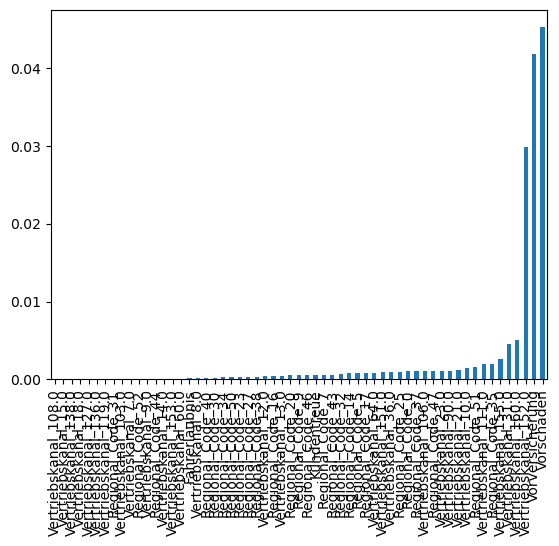

In [42]:
from feature_engineering import evaluate_permuation

results = evaluate_permuation(scaled_df, targets, LogisticRegression(), n_splits=3, n_repeat=40)
results[results > 0].sort_values(ascending=True).plot(kind='bar')

In [200]:
results.loc[dataset_df.columns.difference(["Regional_Code", "Vertriebskanal", "id"])]

Alter             -0.134271
Alter_Fzg         -0.004961
Fahrerlaubnis      0.000121
Geschlecht        -0.002753
Jahresbeitrag     -0.003970
Kundentreue        0.000551
Vorschaden         0.045231
Vorversicherung    0.041856
dtype: float64

In [46]:
model = LogisticRegression()
per_cols = results[results >= 0].index
X_mini = scaled_df[per_cols]


In [47]:
evaluate_model(X_mini.values,
               targets.values,
               LogisticRegression(random_state=42, max_iter=1000),
               n_splits=3)


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning:

The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.



ROC AUC scores for each fold: [0.83461922 0.84028117 0.83543899]
Average ROC AUC: 0.8367797946411578
PR AUC scores for each fold: [0.33702443 0.3446273  0.35408924]
Average PR AUC: 0.34524698650569047
F1 scores for each fold: [0.04192872 0.03463203 0.03964758]
Average F1 score: 0.03873611096618328


In [50]:
evaluate_model(scaled_df.values,
               targets.values,
               model=LogisticRegression(random_state=42, max_iter=1000),
               n_splits=3)


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning:

The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.



ROC AUC scores for each fold: [0.84125596 0.8580271  0.8439914 ]
Average ROC AUC: 0.8477581549979775
PR AUC scores for each fold: [0.35828683 0.37744235 0.36824238]
Average PR AUC: 0.36799051787313664
F1 scores for each fold: [0.13729128 0.08450704 0.10337972]
Average F1 score: 0.10839268135730808


In [51]:
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import f1_score

log_clf = LogisticRegression(max_iter=1000)
rf_clf = RandomForestClassifier(random_state=42)
svc_clf = SVC(probability=True, random_state=42)

ensemble_clf = VotingClassifier(
    estimators=[("lr", log_clf), ("rf", rf_clf), ("svc", svc_clf)],
    voting="soft"
)

ensemble_clf.fit(X_train, y_train)

y_pred = ensemble_clf.predict(X_test)
f1_score(y_pred, y_test)


0.04697986577181208

In [52]:
svc_clf.fit(X_train, y_train)

y_pred = ensemble_clf.predict(X_test)
f1_score(y_pred, y_test)

0.04697986577181208